# Logistic Regression - Multiclass Classification - Batch Gradient Descent


In this notebook, we use Scikit-Learn's **Batch Gradient Descent** algorithm for Logistic Regression to perform multi-class classification.

There are two strategies for multi-class classification:
- One-vesus-all (OvA)
- Multinomial (Softmax)


By default Scikit-Learn’s LogisticRegression uses <strong>one-versus-all</strong> when we train it on more than two classes.

However, we can set the multi_class hyperparameter to "multinomial" to switch it to **Softmax Regression**. 

We will investigate both strategies.


### Solver
- For a brief introduction to various solvers and how they influence the performance of a model, see the notebook **Logistic Regression-5-Gradient Descent Optimization Techniques**.
https://github.com/rhasanbd/Logistic-Regression-Comparative-Understanding/blob/master/Logistic%20Regression-6-Gradient%20Descent%20Optimization%20Techniques.ipynb


### Regularization
We will use regularization (l2 regularization) in our implementation of Logistic Regression. The strength of the regularization is controlled by the hyperparameter C.

### Note on Setting Hyperparameter C

The hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression model is not alpha (as in other linear models), but its inverse C. 

    The higher the value of C, the less the model is regularized.

More on Scikit-Learn's Logistic Regression:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


# Dataset


We will use the iris dataset, which is a multivariate data set. 

This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three different species: Iris-Setosa, Iris-Versicolor, and Iris-Virginica

There are 4 features: 
- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)

Total number of samples: 150

The dataset is also known as Fisher's Iris data set as it was introduced by the British statistician and biologist Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis".


<img src="http://engineering.unl.edu/images/uploads/IrisFlowers.png" width=800, height=400>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

## Explore The Dataset

In [2]:
iris = load_iris()

# See the key values
print("\nKey Values: \n", list(iris.keys()))

# The feature names
print("\nFeature Names: \n", list(iris.feature_names))

# The target names
print("\nTarget Names: \n", list(iris.target_names))

# The target values (codes)
#print("\nTarget Values: \n", list(iris.target))


Key Values: 
 ['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

Feature Names: 
 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Target Names: 
 ['setosa', 'versicolor', 'virginica']


## Create Data Matrix (X) and the Label Array (y)

We can use all features or a subset. For this notebook, we will use two features (i.e., petal length, petal width).

In [3]:
# For the experimentation we use two features
X = iris["data"][:, (2, 3)]  # petal length, petal width

# Target Array
y = iris["target"]

print(X.shape)
print(y.shape)

print("\nX data type: ", X.dtype)
print("y data type: ", y.dtype)

(150, 2)
(150,)

X data type:  float64
y data type:  int64


## Split Data Into Training and Test Sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

## Standardize the Data

In [5]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Scikit-Learn LogisticRegression Attributes Settting

We need to set the following attributes to train a Logistic Regression binary classifier.

- penalty : ‘l1’, ‘l2’, ‘elasticnet’, ‘none’ (default=’l2’) The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.


        If penalty is set to ‘elasticnet’, then we need to set the hyperparameter 'l1_ratio'
        
        
- l1_ratio : float, default=None. The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.


- tol : Tolerance for stopping criteria. Default 1e-4.


- C : Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization. Default 1.0


- solver : ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default: ‘liblinear’. Algorithm to use in the optimization problem.

        -- For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

        -- For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

        -- ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.


- max_iter : Useful only for the newton-cg, sag and lbfgs solvers. Maximum number of iterations taken for the solvers to converge. Default 100


- multi_class : ‘ovr’, ‘multinomial’, ‘auto’. default: ‘ovr’. 
    -- If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.

## Investigation of the Multi-Class Classification Techniques

Below we investigate two strategies for multi-class classification:
- One-vesus-all (OvA)
- Multinomial (Softmax)

# One-versus-All (OvA) Multi-class Classification

The OvA strategy trains multiple binary classifiers.

For the the 3 classes of the Iris dataset, OvA will trail 3 binary classifiers.

- We will see that the $n\_iter\_$ attribute of the LogisticRegression object will return an array of 3 iteration counts.

## Model Selection for OvA: Hyperparameter Tuning

First, we need to find the optimal hyperparameters via Gridsearch.

- Solver: Note that we select the best solver for the batch Gradient Descent from 'liblinear', ‘newton-cg’, and ‘lbfgs’. The other two solvers ‘sag’ and ‘saga’ implement a variant of SGD. For this illustration we exclude the SGD solvers. 

In [6]:
%%time
param_grid = {'solver': ['liblinear', 'newton-cg', 'lbfgs'], 
              'multi_class' : ['ovr'],
              'tol': [1e-3, 1e-4], 'max_iter':[500, 1000],'C': [0.1, 0.5, 1, 10, 15, 50, 100]}

lg_reg = LogisticRegression()

lg_reg_cv = GridSearchCV(lg_reg, param_grid, scoring='f1_micro', cv=3, verbose=1, n_jobs=-1)
lg_reg_cv.fit(X_train, y_train)

params_optimal = lg_reg_cv.best_params_

print("Best Score (F1 score): %f" % lg_reg_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s


Best Score (F1 score): 0.958333
Optimal Hyperparameter Values:  {'C': 10, 'max_iter': 500, 'multi_class': 'ovr', 'solver': 'newton-cg', 'tol': 0.001}


CPU times: user 347 ms, sys: 87.6 ms, total: 435 ms
Wall time: 1.97 s


[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:    1.9s finished


## Train the Optimal Logistic Regression Classifier

In [7]:
lg_reg_ova = LogisticRegression(**params_optimal)

lg_reg_ova.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.001, verbose=0,
                   warm_start=False)

## Evaluate the Optimal Classifier on Test Data

In [8]:
print("No. of Iterations:",lg_reg_ova.n_iter_ )

y_test_predicted = lg_reg_ova.predict(X_test)
#print(y_test_predict)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [8 6 9]

Test Accuracy:  0.9666666666666667

Test Confusion Matrix:
[[14  0  0]
 [ 0  7  1]
 [ 0  0  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.88      0.93         8
           2       0.89      1.00      0.94         8

    accuracy                           0.97        30
   macro avg       0.96      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



## Observation: OvA

We observe that the $n\_iter\_$ attribute of the LogisticRegression object returns an array of 3 iteration counts. This illustrates an **important difference of the OvA with the Softmax regression**.

In the OvA strategy we train multiply binary classifiers. In this 3 class classification problem, the LogisticRegression object has trained 3 models.

However, in the Softmax regression we train a single model for identifying multiple classes. 

    That's why we prefer to use Softmax regression for multi-class classification.


# Siftmax Regression Multi-class Classification


## Model Selection for Softmax Regression: Hyperparameter Tuning

First, we need to find the optimal hyperparameters via Gridsearch.

- Solver: Note that we select the best solver for the batch Gradient Descent from ‘newton-cg’, and ‘lbfgs’. We exclude 'liblinear' because it only implements the OvA approach. The other two solvers ‘sag’ and ‘saga’ implement a variant of SGD. For this illustration we exclude the SGD solvers. 

In [9]:
%%time

param_grid_sm = {'solver': ['newton-cg', 'lbfgs'], 
              'multi_class' : ['multinomial'],
              'tol': [1e-3, 1e-4], 'max_iter':[500, 1000],'C': [0.1, 0.5, 1, 10, 15, 50, 100]}

lg_reg_sm = LogisticRegression()

lg_reg_sm_cv = GridSearchCV(lg_reg_sm, param_grid_sm, scoring='f1_micro', cv=3, verbose=1, n_jobs=-1)
lg_reg_sm_cv.fit(X_train, y_train)

params_optimal_sm = lg_reg_sm_cv.best_params_

print("Best Score (accuracy): %f" % lg_reg_sm_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sm)
print("\n")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 56 candidates, totalling 168 fits
Best Score (accuracy): 0.966667
Optimal Hyperparameter Values:  {'C': 50, 'max_iter': 500, 'multi_class': 'multinomial', 'solver': 'newton-cg', 'tol': 0.001}


CPU times: user 160 ms, sys: 7.81 ms, total: 168 ms
Wall time: 431 ms


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    0.4s finished


## Train the Optimal Softmax Logistic Regression Classifier

In [10]:
log_reg_softmax = LogisticRegression(**params_optimal_sm)

log_reg_softmax.fit(X_train, y_train)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.001, verbose=0,
                   warm_start=False)

## Evaluate the Optimal Classifier on Test Data

In [11]:
print("No. of Iterations:", log_reg_softmax.n_iter_ )

y_test_predicted = log_reg_softmax.predict(X_test)
#print(y_test_predict)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [10]

Test Accuracy:  0.9666666666666667

Test Confusion Matrix:
[[14  0  0]
 [ 0  7  1]
 [ 0  0  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.88      0.93         8
           2       0.89      1.00      0.94         8

    accuracy                           0.97        30
   macro avg       0.96      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



# Decision Bounday 

Logistic Regression is a **linear classifier**. 

To better understand how Logistic Regression creates linear decision boundary, we need to **visualize** it.


We provide two techniques for plotting the class decision boundary for a multi-class classification problem.

- Using Various Thresholds for a Class Probability
- Using Class Prediction

The 1st technique is useful for understanding the decision boundaries at various thresholds. It reveals the scope of the solution space. We use the function "decision_boundary_various_thresholds" to plot this decision boundary

The 2nd technique is simple and easy to extend for non-linear dataset. We will use it more often. We use the function "decision_boundary_class_colored" to plot this decision boundary. Note that for multi-class classification, the "plotDistanceFromHyperplane" attribute should be set to False.

A detail discussion on these two functions are provided in the "Logistic Regression-1-Binary Classification" notebook.

In [12]:
def decision_boundary_various_thresholds(clf, X):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)

    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]

    # Compute the estimates for 2 classes for all new points
    y_proba = clf.predict_proba(X_new)

    
    # We only use the estimate for the class Iris-Virginica
    zz = y_proba[:, 1].reshape(x1.shape)

    # Generate the contour plot for the estimates of class 1
    contour = plt.contour(x1, x2, zz, cmap=plt.cm.brg)

    plt.clabel(contour, inline=1, fontsize=12)

def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    #plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.summer, alpha=0.9)
    
        
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)    

## Softmax Regression: Decision Boundary for Training Data

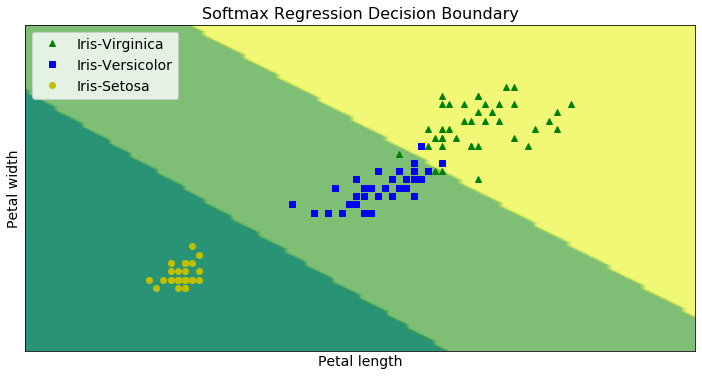

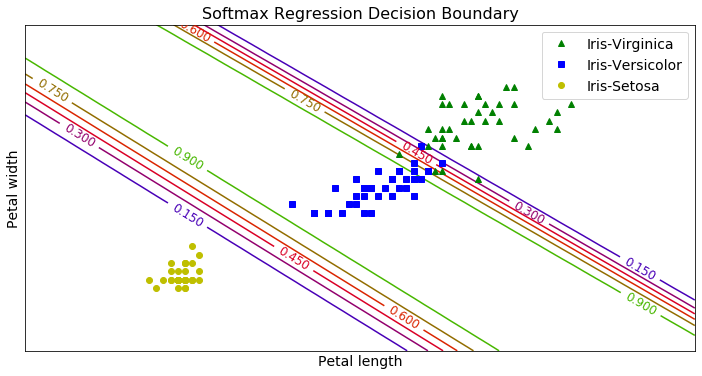

In [13]:
plt.figure(figsize=(12, 6))

decision_boundary_class_colored(log_reg_softmax, X_train, plotDistanceFromHyperplane=False)

plt.plot(X_train[y_train==2, 0], X_train[y_train==2, 1], "g^", label="Iris-Virginica")
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], "yo", label="Iris-Setosa")


plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("Softmax Regression Decision Boundary", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()


plt.figure(figsize=(12, 6))


decision_boundary_various_thresholds(log_reg_softmax, X_train)


plt.plot(X_train[y_train==2, 0], X_train[y_train==2, 1], "g^", label="Iris-Virginica")
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], "yo", label="Iris-Setosa")


plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.title("Softmax Regression Decision Boundary", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Observation 

The first figure shows the resulting decision boundaries, represented by the background colors. 

    Notice that the decision boundaries between any two classes are linear. 

The second figure also the probabilities for two binary classifiers.

## OvA Regression: Decision Boundary for Training Data

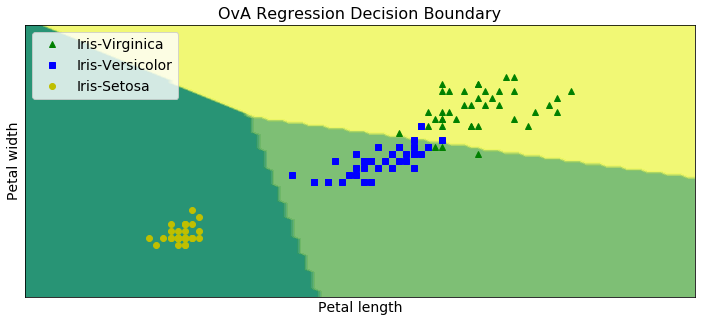

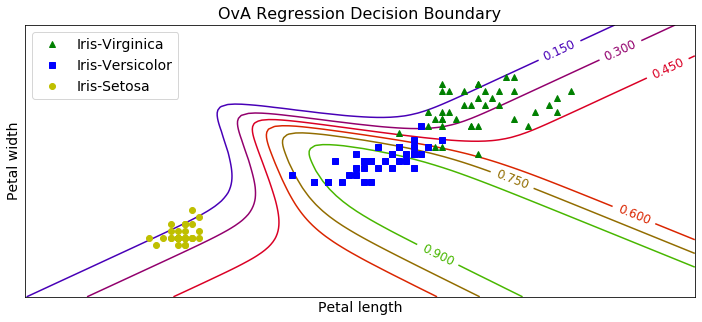

In [14]:
plt.figure(figsize=(12, 5))

decision_boundary_class_colored(lg_reg_ova, X_train, plotDistanceFromHyperplane=False)



plt.plot(X_train[y_train==2, 0], X_train[y_train==2, 1], "g^", label="Iris-Virginica")
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], "yo", label="Iris-Setosa")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("OvA Regression Decision Boundary", fontsize=16)
plt.xticks([])
plt.yticks([])
plt.show()



plt.figure(figsize=(12, 5))



decision_boundary_various_thresholds(lg_reg_ova, X_train)


plt.plot(X_train[y_train==2, 0], X_train[y_train==2, 1], "g^", label="Iris-Virginica")
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], "yo", label="Iris-Setosa")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("OvA Regression Decision Boundary", fontsize=16)
plt.xticks([])
plt.yticks([])
plt.show()